# Spring lattice sketch


## Imports


In [3]:
import matplotlib.pyplot as plt
from typing import NamedTuple, Optional, Callable, Dict, Any, Tuple, List, Union
from dataclasses import dataclass
import scipy.io
import jax.numpy as jnp
import pandas as pd
from jax import grad, vmap, jacobian
from jax.experimental.ode import odeint
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type

%matplotlib widget
plt.style.use(["science", "grid"])


ModuleNotFoundError: No module named 'pandas'

## Thermally responsive mass-spring lattice


### Data structure


In [2]:
class ControlParams(NamedTuple):
    reference_points: jnp.ndarray
    young: jnp.ndarray  # Stiffness in the reference configuration. This will be a function of temperature.
    area: jnp.ndarray  # Cross-sectional areas in the reference configuration.
    thermal_strain: jnp.ndarray  # Thermal strain. This will be a function of temperature.
    damping: jnp.ndarray  # Damping coefficient.
    masses: jnp.ndarray  # Masses of the points.
    loading_params: Dict = dict()  # Loading parameters to be passed to loading functions. Default: {}.
    constraint_params: Dict = dict()  # Constraint parameters to be passed to constraint_DOFs_fn. Default: {}.


@dataclass
class Lattice:
    connectivity: jnp.ndarray
    control_params: ControlParams
    solution: Optional[jnp.ndarray] = None

    # Add post init
    def __post_init__(self):
        self.n_points = self.control_params.reference_points.shape[0]
        self.n_bonds = self.connectivity.shape[0]


def plot_lattice(lattice: Lattice, displacement=None, xlim=None, ylim=None, title="Lattice", figsize=(5, 5), annotate=False, bond_values=None, label=None, fontsize=14, cmap="coolwarm", axis=True):
    points = lattice.control_params.reference_points if displacement is None else displacement + lattice.control_params.reference_points
    connectivity = lattice.connectivity

    # Plot the lattice
    fig, ax = plt.subplots(constrained_layout=True, figsize=figsize)
    ax.set_aspect("equal")
    ax.set_xlabel("$x$", fontsize=fontsize)
    ax.set_ylabel("$y$", fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.tick_params(labelsize=0.8*fontsize)
    if not axis:
        ax.axis("off")

    # Plot nodes
    ax.scatter(points[:, 0], points[:, 1], color="black", zorder=10)
    # Plot the bonds
    if bond_values is not None:
        # Color the bonds
        _cmap = plt.cm.get_cmap(cmap)
        norm = plt.Normalize(vmin=bond_values.min(), vmax=bond_values.max())
        colors = _cmap(norm(bond_values))
        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap=_cmap, norm=norm)
        sm.set_array(bond_values)
        cb = fig.colorbar(sm, ax=ax, pad=0.04, aspect=25)
        cb.ax.tick_params(labelsize=0.8*fontsize)
        cb.ax.set_ylabel(label if label is not None else "", fontsize=fontsize)
    else:
        colors = None
    for i, pair in enumerate(connectivity):
        ax.plot(*points[pair].T, lw=2, color="#2980b9" if colors is None else colors[i])

    if annotate:
        for i, pair in enumerate(connectivity):
            ax.annotate(f"{i}", points[pair].mean(axis=0), color="r")
        for id, point in enumerate(points):
            ax.annotate(f"{id}", point)

    # xylim
    x_ext = points[:, 0].max() - points[:, 0].min()
    y_ext = points[:, 1].max() - points[:, 1].min()
    if xlim is None:
        ax.set_xlim(points[:, 0].min() - 0.05*x_ext, points[:, 0].max() + 0.05*x_ext)
    else:
        ax.set_xlim(*xlim)
    if ylim is None:
        ax.set_ylim(points[:, 1].min() - 0.05*y_ext, points[:, 1].max() + 0.05*y_ext)
    else:
        ax.set_ylim(*ylim)

    return fig, ax


### Energy


In [3]:
def build_strain_fn(connectivity):

    def strain_fn(reference_points: jnp.ndarray, displacement: jnp.ndarray):
        current_points = reference_points + displacement
        reference_vectors = reference_points[connectivity[:, 1]] - reference_points[connectivity[:, 0]]
        current_vectors = current_points[connectivity[:, 1]] - current_points[connectivity[:, 0]]
        reference_lengths = jnp.linalg.norm(reference_vectors, axis=-1)
        current_lengths = jnp.linalg.norm(current_vectors, axis=-1)
        strain = (current_lengths - reference_lengths) / reference_lengths
        return strain

    return strain_fn


In [4]:
def build_strain_energy(connectivity):

    def strain_energy(displacement: jnp.ndarray, control_params: ControlParams):
        reference_points = control_params.reference_points
        current_points = reference_points + displacement
        reference_vectors = reference_points[connectivity[:, 1]] - reference_points[connectivity[:, 0]]
        current_vectors = current_points[connectivity[:, 1]] - current_points[connectivity[:, 0]]
        reference_lengths = jnp.linalg.norm(reference_vectors, axis=-1)
        current_lengths = jnp.linalg.norm(current_vectors, axis=-1)
        strain = (current_lengths - reference_lengths) / reference_lengths

        young = control_params.young
        area = control_params.area
        thermal_strain = control_params.thermal_strain

        # NOTE: If we want to include the change of cross-sectional area, we can add it here with a dedicated alpha_transverse.
        # From experiments: alpha_transverse ~ alpha_longitudinal.

        # LTNI --> Neo-hookean
        # return (1/6) * jnp.sum(
        #     young*area*reference_lengths * ( ((1+strain)/(1+thermal_strain))**2 + 2*(1+thermal_strain)/(1+strain) - 3)
        # )

        # HTNI --> Linear        
        return 0.5 * jnp.sum(
            young*area * reference_lengths * ((1+strain)/(1+thermal_strain) - 1)**2
        )

    return strain_energy


### DOFs, geometry, and inertia


In [5]:
def DOFsInfo(n_points: int, constrained_point_DOF_pairs: jnp.ndarray, rigid_bodies_points: List[jnp.ndarray] = []):
    """Computes arrays defining the free, constrained, and all DOFs.

    Args:
        n_points (int): Number of points in the geometry
        constrained_point_DOF_pairs (jnp.ndarray, optional): Array of shape (n_constraints, 2) where each row is of the form [point_id, DOF_id]. Defaults to jnp.array([]).
        rigid_bodies_points (List[jnp.ndarray], optional): List of arrays of shape (n_points_in_rigid_body, ) defining the points in each rigid body. Defaults to [].

    Returns:
        Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]: arrays defining the free, constrained, and all DOFs.
    """

    constrained_DOF_ids = jnp.array([block_id * 2 + DOF_id for block_id, DOF_id in constrained_point_DOF_pairs])
    all_DOF_ids = jnp.arange(n_points * 2)
    free_DOF_ids = jnp.array([dof for dof in all_DOF_ids if dof not in constrained_DOF_ids])

    # Handle rigid body constraints
    if len(rigid_bodies_points) > 0:
        rigid_body_DOF_ids = [jnp.concatenate([(point_id*2 + jnp.arange(2)) for point_id in rigid_body_points])
                              for rigid_body_points in rigid_bodies_points]  # All DOFs of the points in rigid bodies
        # First 3 IDs of the first rigid body are considered as reference (x, y and theta)
        rigid_body_DOF_dependent_ids = jnp.concatenate([DOF_ids[3:] for DOF_ids in rigid_body_DOF_ids])
        # Remove the dependent DOFs from the free DOFs
        free_DOF_ids = jnp.array([dof for dof in free_DOF_ids if dof not in rigid_body_DOF_dependent_ids])
    else:
        rigid_body_DOF_ids = []

    return free_DOF_ids, constrained_DOF_ids, rigid_body_DOF_ids, all_DOF_ids


def points_centroid(points: jnp.ndarray, masses: jnp.ndarray = jnp.array(1.)):
    """Computes the centroid of a set of points.

    Args:
        points (jnp.ndarray): array of shape (n, 2)
        masses (jnp.ndarray, optional): array of shape (n,). Defaults to jnp.array(1.).

    Returns:
        jnp.ndarray: array of shape (2,)
    """

    return ((points.T*masses).T.sum(axis=0)/masses.sum())


def rigid_bodies_inertia(points: jnp.ndarray, masses: jnp.ndarray):
    """Computes the inertia of a set of points moving as one rigid body.

    Args:
        centroids (jnp.ndarray): array of shape (n, 2)
        masses (jnp.ndarray): array of shape (n, 2) of masses.

    Returns:
        jnp.ndarray: inertia of the rigid body
    """

    centroid = points_centroid(points, masses=masses[:, 0])
    mass = jnp.sum(masses[:, 0])

    return jnp.array([
        mass,
        mass,
        jnp.sum(masses[:, 0]*((points - centroid)**2).T)
    ])


def compute_inertia(points: jnp.ndarray, masses: jnp.ndarray, rigid_bodies_points: List[jnp.ndarray] = [],):
    """Computes inertia of the system by taking the masses and modifying the inertia of the rigid bodies.

    Args:
        points (jnp.ndarray): array of shape (n, 2)
        masses (jnp.ndarray): array of shape (n, 2) of masses.
        rigid_bodies_points (List[jnp.ndarray], optional): List of arrays of shape (n_points_in_rigid_body, ) defining the points in each rigid body. Defaults to [].

    Returns:
        jnp.ndarray: array of shape (2*n_points,) collecting the translational and rotational inertia of the system.
    """

    inertia = masses.reshape(-1)

    for rigid_body_points in rigid_bodies_points:
        inertia = inertia.at[rigid_body_points[0]*2:rigid_body_points[0]*2+3].set(
            rigid_bodies_inertia(
                points[rigid_body_points],
                masses[rigid_body_points]
            )
        )

    return inertia


### Constrained kinematics


In [6]:
def rotation_matrix(angle):
    return jnp.array([[jnp.cos(angle), -jnp.sin(angle)],
                      [jnp.sin(angle), jnp.cos(angle)]])


def rigid_body_displacement(DOFs: jnp.ndarray, centroid_points: jnp.ndarray):
    """Computes the displacement of a rigid body from the DOFs of its points.

    Args:
        DOFs (jnp.ndarray): Array of shape (3, 2) containing the DOFs of the rigid body.
        centroid_points (jnp.ndarray): Array of shape (n_points, 2) containing the points of the rigid body in the centroid frame.

    Returns:
        jnp.ndarray: Array of shape (n_points, 2) containing the displacements of the points in the rigid body.
    """

    # Compute the displacement of all the points in the rigid body
    centroid_displacement = DOFs[:2]
    centroid_rotation = DOFs[2]
    point_displacement = centroid_displacement + \
        jnp.dot(rotation_matrix(centroid_rotation) - jnp.eye(2), centroid_points.T).T

    return point_displacement


In [7]:
def build_constrained_kinematics(n_points: int, constrained_point_DOF_pairs: jnp.ndarray, rigid_bodies_points: List[jnp.ndarray] = [], constrained_DOFs_fn: Callable = lambda t, **kwargs: 0):
    """Defines a constrained kinematics of the points.

    Args:
        n_points (int): Number of points in the geometry
        constrained_point_DOF_pairs (jnp.ndarray): Array of shape (n_constraints, 2) where each row is of the form [point_id, DOF_id].
        rigid_bodies_points (List[jnp.ndarray], optional): List of arrays of shape (n_points_in_rigid_body, ) defining the points in each rigid body. Defaults to [].
        constrained_DOFs_fn (Callable, optional): Constraint function defining how the DOFs are driven over time. Output shape should either be scalar or match (len(constrained_point_DOF_pairs),). Valid signature: `constrained_DOFs_fn(t, **kwargs) -> ndarray`. Defaults to lambda t: 0.

    Returns:
        Callable: Constraint function mapping the free DOFs and time to the displacement of all the points. The signature is `constrained_kinematics(free_DOFs, t, constraint_params)`.
    """

    # Retrieve free DOFs from constraints info (this information is assumed to be static)
    free_DOF_ids, constrained_DOF_ids, rigid_body_DOF_ids, all_DOF_ids = DOFsInfo(
        n_points, constrained_point_DOF_pairs, rigid_bodies_points
    )

    def constrained_kinematics(free_DOFs: jnp.ndarray, t, control_params: ControlParams):
        """Constrained kinematics of the blocks.

        Args:
            free_DOFs (jnp.ndarray): Array of shape (n_free_DOFs,) representing the free DOFs.
            t (float): Time parameter for time-dependent constraints.
            control_params (ControlParams): ControlParams.

        Returns:
            jnp.ndarray: Array of shape (n_points, 2) representing the DOFs of all the points.
        """

        all_DOFs = jnp.zeros((len(all_DOF_ids),))
        # Assign imposed displacements along the constrained DOFs
        if len(constrained_DOF_ids) != 0:
            all_DOFs = all_DOFs.at[constrained_DOF_ids].set(
                constrained_DOFs_fn(t, **control_params.constraint_params)
            )
        # Simply assign the free_DOFs along the free DOFs (this acts as the identity operator)
        all_DOFs = all_DOFs.at[free_DOF_ids].set(
            free_DOFs
        )
        # Handle rigid body constraints
        if len(rigid_body_DOF_ids) > 0:
            for rigid_ids, point_ids in zip(rigid_body_DOF_ids, rigid_bodies_points):
                # Retrieve the points of the rigid body in the centroid frame
                centroid_points = control_params.reference_points[point_ids] - points_centroid(
                    control_params.reference_points[point_ids],
                    control_params.masses[point_ids, 0]
                )
                # Compute the displacement of the rigid body points
                all_DOFs = all_DOFs.at[rigid_ids].set(
                    rigid_body_displacement(all_DOFs[rigid_ids[:3]], centroid_points).reshape(-1)
                )

        return all_DOFs.reshape((n_points, 2))

    return constrained_kinematics


def constrain_energy(energy_fn: Callable, constrained_kinematics: Callable):
    """Defines a constrained version of `energy_fn` according to `constrained_kinematics`.

    Args:
        energy_fn (Callable): Energy functional to be constrained.
        constrained_kinematics (Callable): Constraint function mapping the free DOFs and time to the displacement of all the points. Normally, this is the output of `build_constrained_kinematics`.

    Returns:
        Callable: Constrained energy functional with signature (free_dofs, time, control_params) -> energy.
    """

    def constrained_energy_fn(free_DOFs: jnp.ndarray, t, control_params: ControlParams):
        return energy_fn(
            constrained_kinematics(free_DOFs, t, control_params),
            control_params
        )

    return constrained_energy_fn


### Loading function


In [8]:
def build_loading(
        n_points: int,
        loaded_point_DOF_pairs: jnp.ndarray,
        loading_fn: Callable,
        constrained_point_DOF_pairs: jnp.ndarray = jnp.array([]),
        rigid_bodies_points: List[jnp.ndarray] = [],):
    """Defines the loading function.

    Args:
        n_points (int): Number of points in the geometry.
        loaded_point_DOF_pairs (jnp.ndarray): array of shape (Any, 2) where each row defines a pair of [point_id, DOF_id] where DOF_id is either 0, 1, or 2
        loading_fn (Callable): Loading function. Output shape should either be scalar or match (len(loaded_point_DOF_pairs),).
        constrained_point_DOF_pairs (jnp.ndarray, optional): Array of shape (n_constraints, 2) where each row is of the form [point_id, DOF_id]. Defaults to jnp.array([]).
        rigid_bodies_points (List[jnp.ndarray], optional): List of arrays of shape (n_points_in_rigid_body, ) defining the points in each rigid body. Defaults to [].

    Returns:
        Callable: vector loading function evaluating to `loading_fn` for the DOFs defined by `loaded_point_DOF_pairs` and 0 otherwise.
    """

    # loaded DOF ids based on global numeration
    loaded_DOF_ids = jnp.array([point_id * 2 + DOF_id for point_id, DOF_id in loaded_point_DOF_pairs])
    # Retrieve free DOFs from constraints info (this information is assumed to be static)
    free_DOF_ids, _, _, all_DOF_ids = DOFsInfo(n_points, constrained_point_DOF_pairs, rigid_bodies_points)

    def _loading_fn(state, t, loading_params: Dict):

        loading_vector = jnp.zeros((len(all_DOF_ids),))
        if len(loaded_point_DOF_pairs) != 0:
            loading_vector = loading_vector.at[loaded_DOF_ids].set(
                loading_fn(state, t, **loading_params)
            )
        loading_vector = loading_vector[free_DOF_ids]  # Reduce loading vector to the free DOFs

        return loading_vector

    return _loading_fn


### ODE solver


In [9]:
def setup_dynamic_solver(
        lattice: Lattice,
        loaded_point_DOF_pairs: jnp.ndarray = jnp.array([]),
        loading_fn:  Callable = lambda state, t: 0,
        constrained_point_DOF_pairs: jnp.ndarray = jnp.array([]),
        rigid_bodies_points: List[jnp.ndarray] = [],
        constrained_DOFs_fn: Callable = lambda t, **kwargs: 0,
        control_params_fn: Callable = lambda t, control_params: control_params,):

    # Energy
    total_energy = build_strain_energy(lattice.connectivity)
    # NOTE: Handle constraints
    constrained_kinematics = build_constrained_kinematics(
        n_points=lattice.n_points,
        constrained_point_DOF_pairs=constrained_point_DOF_pairs,
        rigid_bodies_points=rigid_bodies_points,
        constrained_DOFs_fn=constrained_DOFs_fn,
    )
    constrained_energy = constrain_energy(energy_fn=total_energy, constrained_kinematics=constrained_kinematics)
    # NOTE: Handle loading
    loading = build_loading(
        n_points=lattice.n_points,
        loaded_point_DOF_pairs=loaded_point_DOF_pairs,
        loading_fn=loading_fn,
        constrained_point_DOF_pairs=constrained_point_DOF_pairs,
        rigid_bodies_points=rigid_bodies_points,
    )

    # Right hand side of the ODE
    potential_force = grad(lambda x, *args, **kwargs: -constrained_energy(x, *args, **kwargs))

    # Retrieve free DOFs from constraints info (this information is assumed to be static)
    free_DOF_ids, _, _, all_DOF_ids = DOFsInfo(lattice.n_points, constrained_point_DOF_pairs, rigid_bodies_points)
    n_all_DOFs = len(all_DOF_ids)

    # Utility functions to reconstruct the full state array from the solution of the free DOFs
    kinematics_history_fn = vmap(constrained_kinematics, in_axes=(0, 0, None))
    jac_kinematics = jacobian(constrained_kinematics, argnums=(0, 1))

    def velocity_fn(free_DOFs, free_DOFs_dot, t, control_params: ControlParams):
        du_dfree, du_dt = jac_kinematics(free_DOFs, t, control_params)
        return du_dfree @ free_DOFs_dot + du_dt

    velocity_history_fn = vmap(velocity_fn, in_axes=(0, 0, 0, None))

    def rhs(state, t, control_params: ControlParams, inertia: jnp.ndarray):
        _control_params = control_params_fn(t, control_params)
        x, x_dot = state
        return jnp.array([
            x_dot,
            (potential_force(x, t, _control_params) + loading(state, t, _control_params.loading_params) -
             _control_params.damping*x_dot) / inertia
        ])

    def solve_dynamics(state0, timepoints, control_params: ControlParams):
        """Solves the dynamics via `odeint`.

        Args:
            state0 (jnp.ndarray): array of shape (2, n_points, 2) representing the initial conditions.
            timepoints (jnp.ndarray): evaluation times.
            control_params (ControlParams): control parameters.

        Returns:
            ndarray: Solution of the dynamics evaluated at times `timepoints`. Shape (n_timepoints, 2, n_points, 2), axis 0 is time, axis 1 is state (displacement, velocity), axis 2 is point id, axis 3 is DOF.
        """

        # Reduce state0, masses, and damping to the free DOFs
        _state0 = state0.reshape((2, n_all_DOFs))[:, free_DOF_ids]
        inertia = compute_inertia(
            control_params.reference_points,
            control_params.masses,
            rigid_bodies_points=rigid_bodies_points,
        )[free_DOF_ids]
        _control_params = control_params._replace(damping=control_params.damping.reshape((n_all_DOFs,))[free_DOF_ids])

        # Solve ODE
        free_DOFs_solution = odeint(rhs, _state0, timepoints, _control_params, inertia)

        # Reshape solution to global state.
        kinematic_history = kinematics_history_fn(
            free_DOFs_solution[:, 0, :],
            timepoints,
            control_params
        )
        velocity_history = velocity_history_fn(
            free_DOFs_solution[:, 0, :],
            free_DOFs_solution[:, 1, :],
            timepoints,
            control_params
        )
        solution = jnp.zeros((len(timepoints), 2, lattice.n_points, 2))
        solution = solution.at[:, 0, :, :].set(kinematic_history)
        solution = solution.at[:, 1, :, :].set(velocity_history)

        return solution

    return solve_dynamics, rhs


## Example


In [48]:
points = jnp.array([[0., 0], [1, 0], [1, 1], [0, 1]])
connectivity = jnp.array([[0, 1], [1, 2], [2, 3], [3, 0], [1, 3]])
n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,
    young=jnp.ones(n_bonds),
    area=jnp.ones(n_bonds),
    thermal_strain=0.1*jnp.ones(n_bonds),
    damping=0.1*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Lattice'}, xlabel='$x$', ylabel='$y$'>)

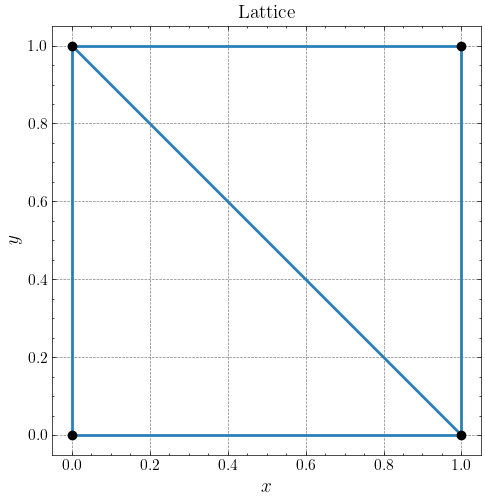

In [11]:
plot_lattice(lattice)


### Free space


In [12]:
# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])
timepoints = jnp.linspace(0, 100, 200)

solve_dynamics, _ = setup_dynamic_solver(lattice=lattice)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Final state'}, xlabel='$x$', ylabel='$y$'>)

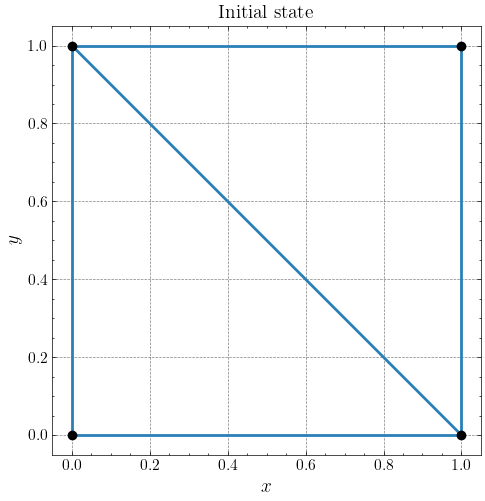

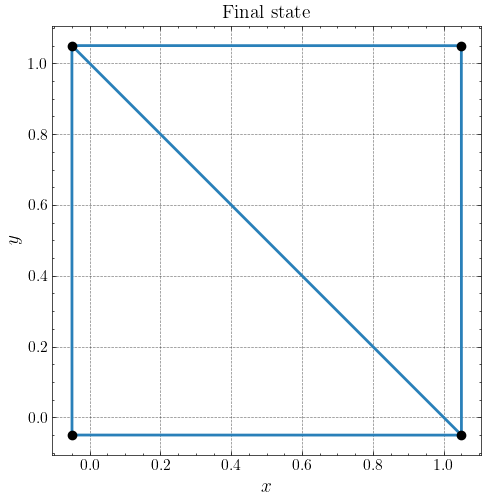

In [13]:
plot_lattice(lattice, lattice.solution[0, 0], title='Initial state')
plot_lattice(lattice, lattice.solution[-1, 0], title='Final state')


### Bottom nodes constrained


In [14]:
# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])
timepoints = jnp.linspace(0, 100, 200)

solve_dynamics, _ = setup_dynamic_solver(
    lattice=lattice,
    constrained_point_DOF_pairs=jnp.array([[0, 0], [0, 1], [1, 0], [1, 1]]),
)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Final state'}, xlabel='$x$', ylabel='$y$'>)

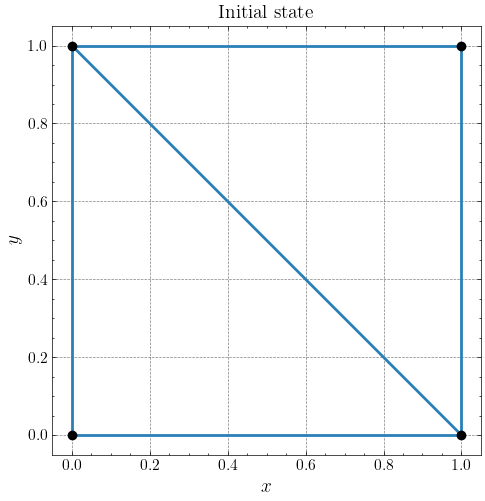

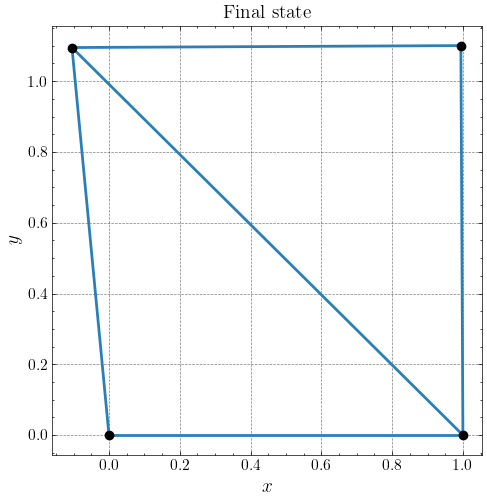

In [15]:
plot_lattice(lattice, lattice.solution[0, 0], title='Initial state')
plot_lattice(lattice, lattice.solution[-1, 0], title='Final state')


### Free space, variable params


In [16]:
# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])
timepoints = jnp.linspace(0, 100, 200)


def control_params_fn(t, control_params: ControlParams):
    # NOTE: This will be replace by the experimental temperature-dependent behavior.
    return control_params._replace(
        young=control_params.young,
        thermal_strain=control_params.thermal_strain*2*(t/timepoints[-1]),
    )


solve_dynamics, _ = setup_dynamic_solver(lattice=lattice, control_params_fn=control_params_fn)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Final state'}, xlabel='$x$', ylabel='$y$'>)

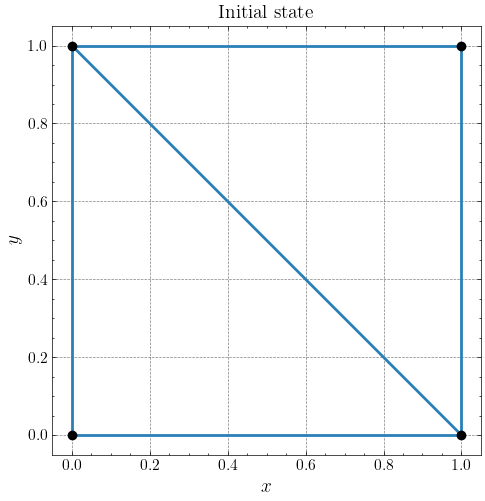

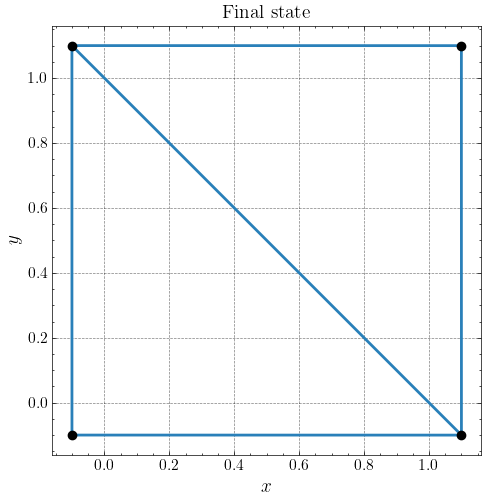

In [17]:
plot_lattice(lattice, lattice.solution[0, 0], title='Initial state')
plot_lattice(lattice, lattice.solution[-1, 0], title='Final state')


In [18]:
# TODO: Import Arda's data for Young and alpha parameters as a function of temperature.
# TODO: Choose simple temperature dependence for Young and alpha based on Arda's data.
# TODO: Implement the triangular topology.
# TODO: Define a forward function taking a final temperature and simulate the response of the lattice (homogeneous to start with).

### Import experimental data

In [10]:
exp_actuation_strain = pd.read_csv('../../data/LCE Lattices/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv').drop(['Unnamed: 3'], axis=1)
exp_modulus_stress = pd.read_csv('../../data/LCE Lattices/LTNI and HTNI LCE strains and moduli from Arda.csv')
exp_modulus_stress.drop(exp_modulus_stress.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, -1]], axis=1, inplace=True)
exp_modulus_stress.columns = exp_modulus_stress.iloc[0]
exp_modulus_stress.drop(0, inplace=True)

HTNI_stretch_data = exp_actuation_strain[['temp [C]', 'AVG HTNI', 'STD HTNI']].astype(float)
LTNI_stretch_data = exp_actuation_strain[['temp [C]', 'AVG LTNI', 'STD LTNI']].astype(float)

HTNI_modulus_data = exp_modulus_stress[['Temp [C] corresponding to HTNI data', 'Avg Youngs Modulus of HTNI [Mpa]']].dropna().astype(float)
LTNI_modulus_data = exp_modulus_stress[['Temp [C] corresponding to LTNI data', 'Avg Youngs Modulus of LTNI [Mpa]']].dropna().astype(float)

sampled_temps = jnp.array([22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130])
ts = jnp.linspace(0, 600, len(sampled_temps)) # used for interpolation

# Experimental tracking data
LTNI_x_pos = scipy.io.loadmat('../../exp/LCE_lattices/20230609_F1_LTNI/LTNI_x_positions.mat')['LTNI_x_positions'] # [mm] <num nodes x num sampled temps>
LTNI_y_pos = scipy.io.loadmat('../../exp/LCE_lattices/20230609_F1_LTNI/LTNI_y_positions.mat')['LTNI_y_positions'] # [mm] <num nodes x num sampled temps>
HTNI_x_pos = scipy.io.loadmat('../../exp/LCE_lattices/20230609_G1_HTNI/HTNI_x_positions.mat')['HTNI_x_positions'] # [mm] <num nodes x num sampled temps>
HTNI_y_pos = scipy.io.loadmat('../../exp/LCE_lattices/20230609_G1_HTNI/HTNI_y_positions.mat')['HTNI_y_positions'] # [mm] <num nodes x num sampled temps>

In [11]:
def T(time):
    return jnp.interp(time, ts, sampled_temps)

def HTNI_stretch(temperature): # normalized length
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))

def LTNI_stretch(temperature): # normalized length
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))

def LTNI_young_fit(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data['Temp [C] corresponding to LTNI data']), jnp.array(LTNI_modulus_data['Avg Youngs Modulus of LTNI [Mpa]']))

def HTNI_young_fit(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data['Temp [C] corresponding to HTNI data']), jnp.array(HTNI_modulus_data['Avg Youngs Modulus of HTNI [Mpa]']))


## Use experimental material parameters

In [12]:
def triangular_lattice_points(n1: int, n2: int, spacing: float): 
    row = jnp.array([jnp.arange(n1+1), jnp.zeros(n1+1)]).T * spacing
    return jnp.concatenate(
        [
            row[:n1+1-jnp.mod(i, 2)] + jnp.array([
                jnp.mod(i, 2)*jnp.cos(jnp.pi/3),
                i*jnp.sin(jnp.pi/3)
            ])*spacing
            for i in range(n2+1)]
    )


def triangular_lattice_connectivity(n1: int, n2: int):
    horizontal_bonds_even = jnp.concatenate(
        [jnp.array([jnp.arange(n1)+i*(2*n1+1), jnp.arange(n1)+i*(2*n1+1)+1]).T for i in range(n2//2+1)])
    horizontal_bonds_odd = jnp.concatenate(
        [jnp.array([jnp.arange(n1-1)+(i+1)*(n1+1)+i*n1, jnp.arange(n1-1)+(i+1)*(n1+1)+i*n1+1]).T for i in range(n2//2)])

    right_leaning_even = jnp.concatenate(
        [jnp.array([jnp.arange(n1), jnp.arange(n1)+n1+1]).T + i*(2*n1+1) for i in range(n2//2)])
    right_leaning_odd = jnp.concatenate(
        [jnp.array([jnp.arange(n1), jnp.arange(n1)+n1+1]).T + i*(2*n1+1) + n1+1 for i in range(n2//2)])

    left_leaning_even = jnp.concatenate(
        [jnp.array([jnp.arange(n1)+1, jnp.arange(n1)+1+n1]).T + i*(2*n1+1) for i in range(n2//2)])
    left_leaning_odd = jnp.concatenate(
        [jnp.array([jnp.arange(n1)+1, jnp.arange(n1)+1+n1]).T + i*(2*n1+1) + n1 for i in range(n2//2)])

    connectivity = jnp.concatenate([horizontal_bonds_even, horizontal_bonds_odd,
                                    right_leaning_even, right_leaning_odd, left_leaning_even, left_leaning_odd])
    return connectivity


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Lattice'}, xlabel='$x$', ylabel='$y$'>)

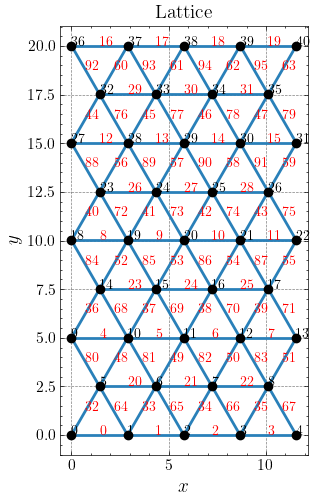

In [13]:
n1 = 4
n2 = 8

spacing = HTNI_y_pos[1, 0] - HTNI_y_pos[2, 0] # needs to be manually determined bc of inconsistent indexing
# spacing = 1.
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity = triangular_lattice_connectivity(n1=n1, n2=n2)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,
    young=jnp.ones(n_bonds),
    area=jnp.ones(n_bonds),
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.1*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
plot_lattice(lattice, annotate=True, figsize=(5, 5))

In [14]:
# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])
timepoints = jnp.linspace(0, ts[-1], 500)


def control_params_fn(t, control_params: ControlParams):
    # NOTE: This will be replace by the experimental temperature-dependent behavior.
    return control_params._replace(
        young = jnp.ones(n_bonds)*HTNI_young_fit(T(t)),
        # young=control_params.young,
        thermal_strain = jnp.ones(n_bonds)*(HTNI_stretch(T(t))-1)*0.8
        # thermal_strain=control_params.thermal_strain*(t/timepoints[-1]),
    )


solve_dynamics, _ = setup_dynamic_solver(
    lattice=lattice,
    control_params_fn=control_params_fn,
    constrained_point_DOF_pairs=jnp.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [
                                          2, 1], [3, 0], [3, 1], [4, 0], [4, 1]]),
    rigid_bodies_points=[jnp.arange(lattice.n_points-n1-1, lattice.n_points)],  # Last row is a rigid body
)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)

strain_fn = build_strain_fn(lattice.connectivity)


(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:title={'center':'Final state'}, xlabel='$x$', ylabel='$y$'>)

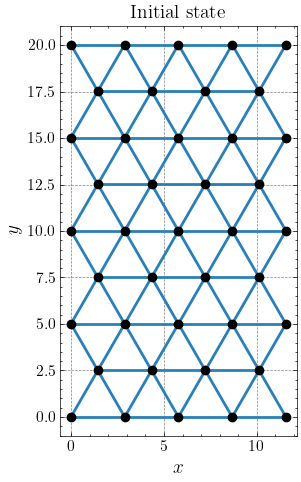

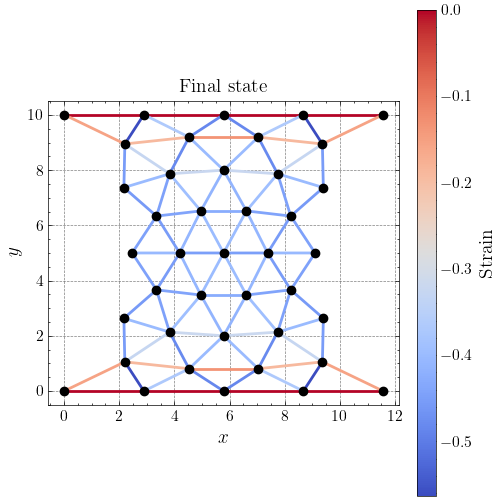

In [15]:
plot_lattice(lattice, lattice.solution[0, 0], title='Initial state', figsize=(3, 6))
plot_lattice(lattice, lattice.solution[-1, 0], title='Final state', figsize=(5, 5),
             bond_values=strain_fn(lattice.control_params.reference_points, lattice.solution[-1, 0]),
             label='Strain')


### HTNI Numerical and Experimental comparison

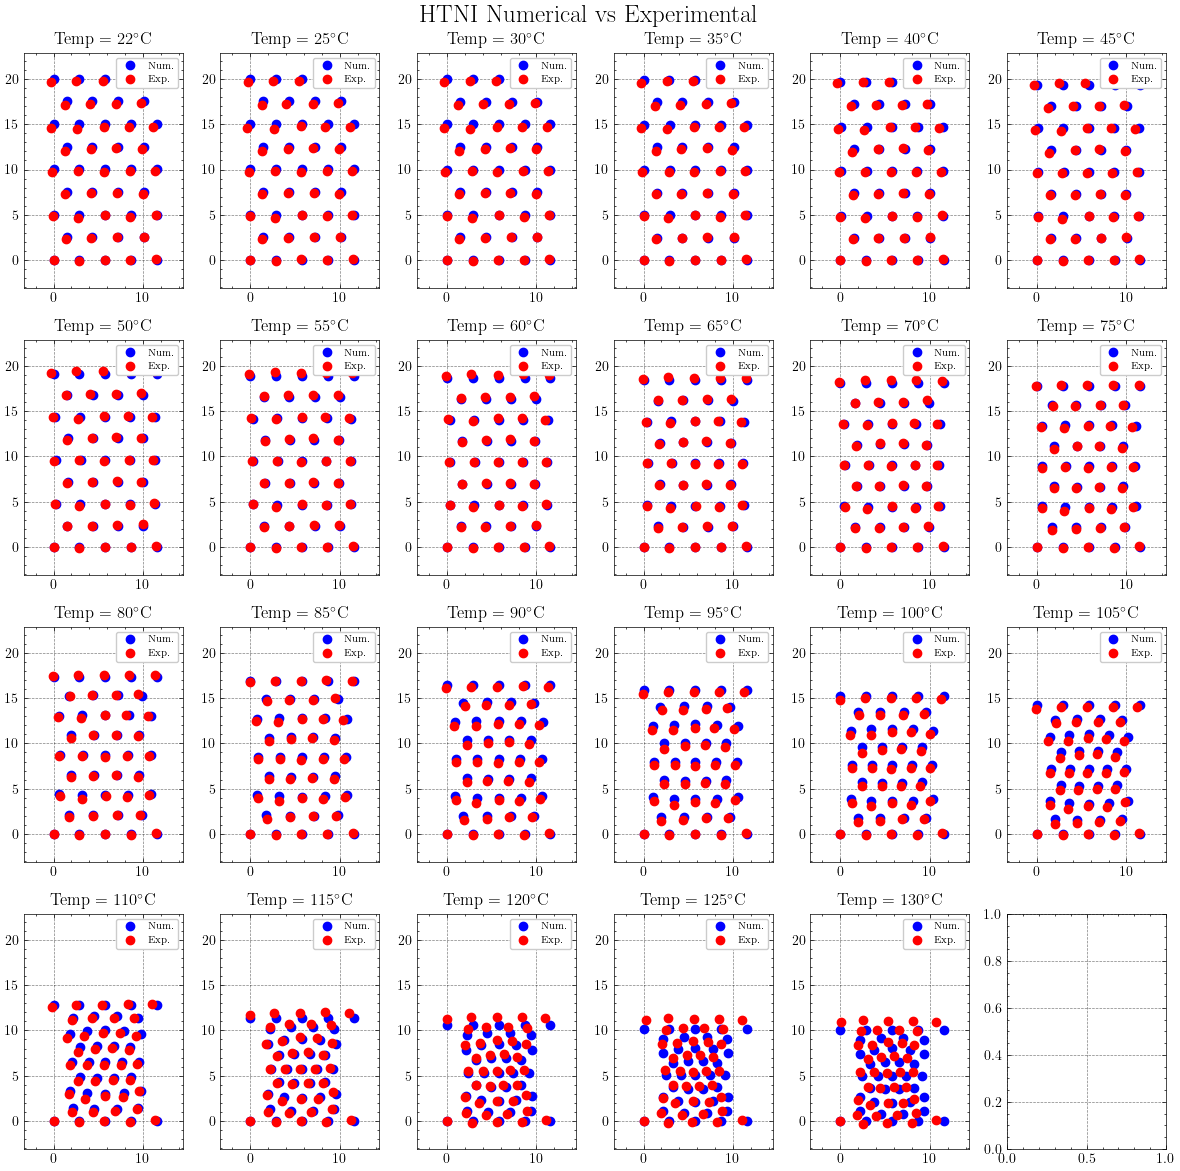

In [16]:
temp_evolution = T(timepoints) # temperature evolution over time used in numerical simulations

fig, ax = plt.subplots(4, 6, figsize = [12, 12])

# HTNI_err = jnp.zeros(len(sampled_temps))

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            ax[i, j].plot(points[:, 0]+lattice.solution[timepoint_near_temp_i, 0, :, 0], points[:, 1]+lattice.solution[timepoint_near_temp_i, 0, :, 1], 'bo', label='Num.')
            ax[i, j].plot(HTNI_y_pos[:, exp_idx_i], HTNI_x_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_xlim([min(HTNI_y_pos[:, 0]) - 3, max(HTNI_y_pos[:, 0]) + 3])
            ax[i, j].set_ylim([min(HTNI_x_pos[:, 0]) - 3, max(HTNI_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

            # not currently valid because the ordering of the experimental data points is not in any coherent order
            # HTNI_err = HTNI_err.at[counter].set(jnp.sum(jnp.sqrt((HTNI_y_pos[:, exp_idx_i] - (points[:, 0]+lattice.solution[timepoint_near_temp_i, 0, :, 0]))**2 + (HTNI_x_pos[:, exp_idx_i] - (points[:, 1]+lattice.solution[timepoint_near_temp_i, 0, :, 1]))**2)))

plt.suptitle('HTNI Numerical vs Experimental', fontsize=18)
plt.tight_layout()

### LTNI Numerical and Experimental Comparison

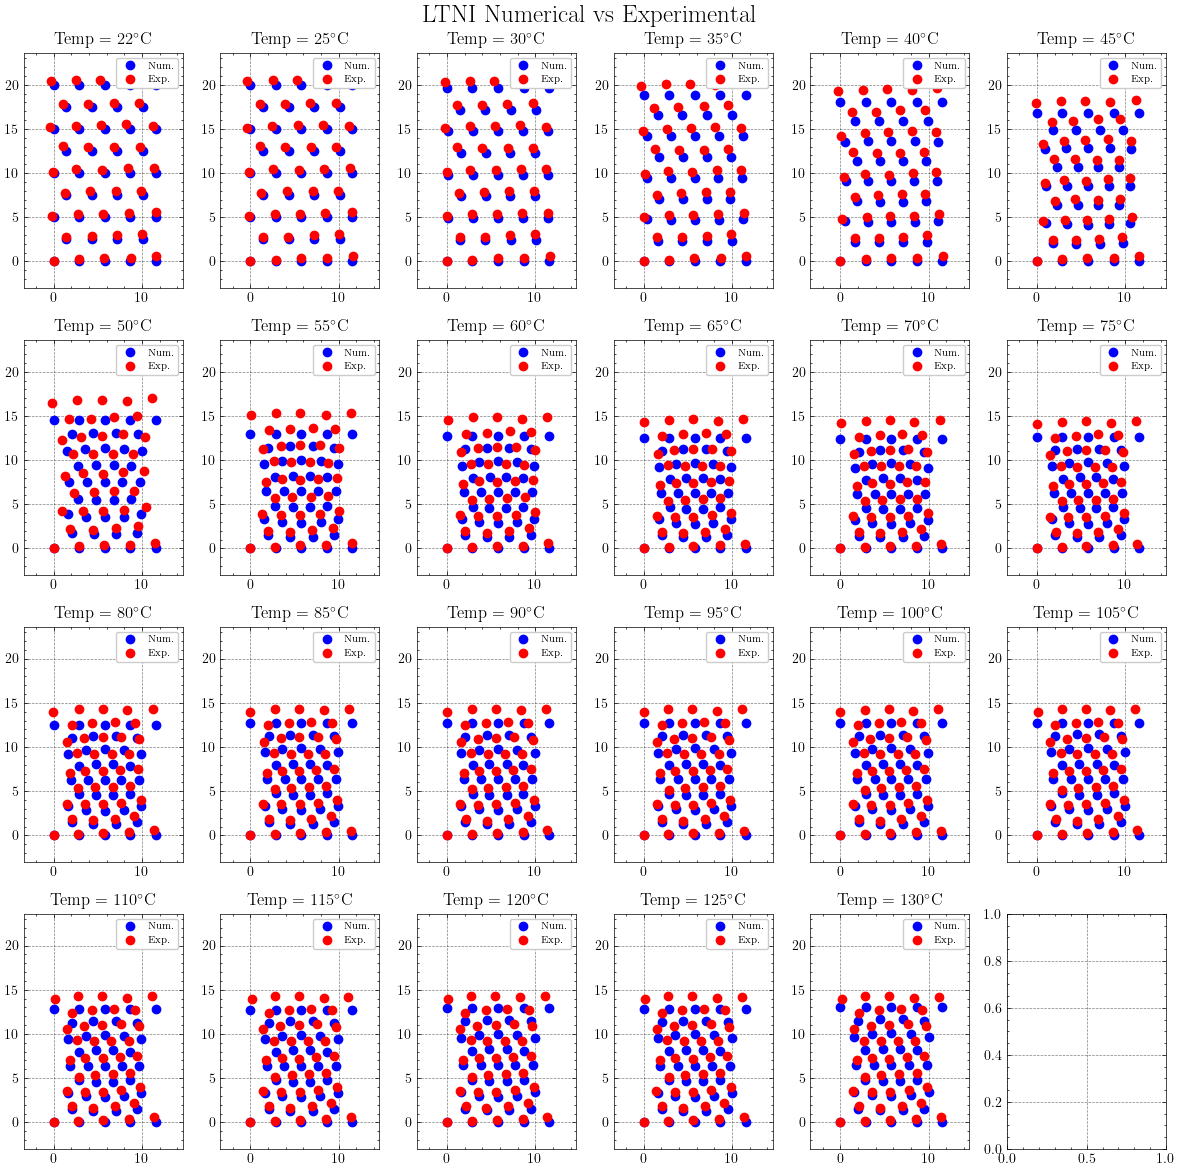

In [20]:
temp_evolution = T(timepoints) # temperature evolution over time used in numerical simulations

fig, ax = plt.subplots(4, 6, figsize = [12, 12])

# LTNI_err = jnp.zeros(len(sampled_temps))

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            ax[i, j].plot(points[:, 0]+lattice.solution[timepoint_near_temp_i, 0, :, 0], points[:, 1]+lattice.solution[timepoint_near_temp_i, 0, :, 1], 'bo', label='Num.')
            ax[i, j].plot(LTNI_y_pos[:, exp_idx_i], LTNI_x_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_xlim([min(LTNI_y_pos[:, 0]) - 3, max(LTNI_y_pos[:, 0]) + 3])
            ax[i, j].set_ylim([min(LTNI_x_pos[:, 0]) - 3, max(LTNI_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

            # not currently valid because the ordering of the experimental data points is not in any coherent order
            # LTNI_err = LTNI_err.at[counter].set(jnp.sum(jnp.sqrt((LTNI_y_pos[:, exp_idx_i] - (points[:, 0]+lattice.solution[timepoint_near_temp_i, 0, :, 0]))**2 + (LTNI_x_pos[:, exp_idx_i] - (points[:, 1]+lattice.solution[timepoint_near_temp_i, 0, :, 1]))**2)))

plt.suptitle('LTNI Numerical vs Experimental', fontsize=18)
plt.tight_layout()